In [33]:
import matplotlib.pyplot as plt
import math
import gmpy2
import time
import numpy as np

# This is how to accurately calculate large numbers using mpfr at very high precision
start_time = time.time()
PRECISION = 1000

def power(x, n):
    result = 1
    for i in range(n):
        result = gmpy2.mul(result, x)
    return result

# Define a function to calculate the factorial of n using gmpy2
def fractional_error(n):
    with gmpy2.local_context(gmpy2.context(), precision=PRECISION) as ctx:
        factorial = gmpy2.factorial(n)
        square_root = gmpy2.sqrt(2 * math.pi * n) # Part of Stirling's approximation
        exponential = gmpy2.exp(-n) * power(n, n) # Second part of Stirling's approximation
        ans = (gmpy2.sub(factorial, gmpy2.mul(square_root, exponential))) / factorial
        return ans

# test case
# gmpy2.get_context().precision=PRECISION
# print(gmpy2.get_context())
TEST_NUMBER = 1000
TEST_OUTPUT = fractional_error(TEST_NUMBER)
print(f"Fractional error for {TEST_NUMBER} is {TEST_OUTPUT:.10f}") # 0.8f cuts off after 8 decimal places

# finding the number...
def find_closest_to_x(x, start, end):
    mid = int((start + end) / 2)
    if start == mid:
        return mid
    elif fractional_error(mid) < x:
        return find_closest_to_x(x, start, mid+1)
    else:
        return find_closest_to_x(x, mid+1, end)
ANSWER = find_closest_to_x(1e-6, 0, 100000)
print(f"Answer is {ANSWER}")
print(f"Fractional error for {ANSWER} is {fractional_error(ANSWER):.15f}")

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.2f} seconds")

Fractional error for 1000 is 0.0000833299
Answer is 83334
Fractional error for 83334 is 0.000000999991500
Elapsed time: 4.66 seconds


Fractional error for 100 is 0.000832983432148802
Fractional error for 100 is 0.000833
Overflow error at 171


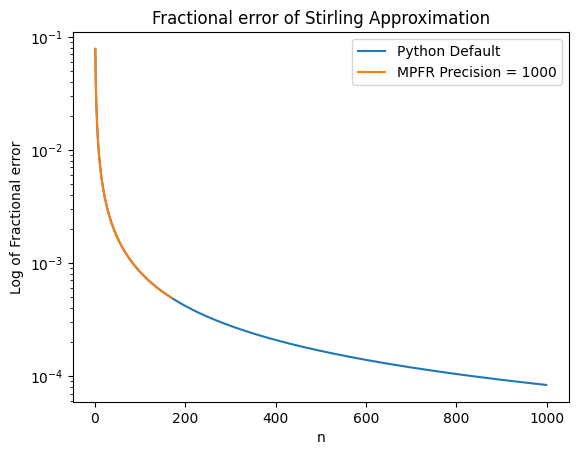

In [12]:
# Calculating fractional error using Stirling's approximation
def stirling_factorial(n):
    if n == 0:
        return 1
    else:
        return (np.sqrt(2*np.pi*n))*np.power((n/np.e), (n))
    
def fractional_error_v2(n):
    factorial = float(math.factorial(n))
    stirling = stirling_factorial(n)
    ans = (factorial - stirling) / factorial
    return ans

TEST_NUMBER_2 = 100
print(f"Fractional error for {TEST_NUMBER_2} is {fractional_error_v2(TEST_NUMBER_2)}")
print(f"Fractional error for {TEST_NUMBER_2} is {fractional_error(TEST_NUMBER_2)}")

# Find where fractional_error_v2 has overflow error
def find_overflow_error(n):
    try:
        fractional_error_v2(n)
    except OverflowError:
        return n
    return find_overflow_error(n + 1)

OVERFLOW_ERROR = find_overflow_error(100)
print(f"Overflow error at {OVERFLOW_ERROR}")

# Plotting the fractional error for both methods 
x = list(range(1, 1000)) # n = 1 to 100000
x2 = list(range(1, OVERFLOW_ERROR))
y = [fractional_error(n) for n in x]
y2 = [fractional_error_v2(n) for n in x2]

plt.plot(x, y, label='Python Default')
plt.plot(x2, y2, label='MPFR Precision = 1000')
plt.legend()
plt.xlabel('n')
plt.ylabel('Log of Fractional error')
plt.title('Fractional error of Stirling Approximation')
plt.yscale('log')

In [13]:
# 24 bit Floating point precision
# Assume 1 sign bit, 8 bit exponent, 15 + 1 bit significand

def int_to_24_bit_float(integer):
    if integer < 0:
        sign_bit = 1
        integer = abs(integer)
    else:
        sign_bit = 0

    bit_rep = bin(integer)[2:] # Convert to binary representation and remove the '0b' prefix

    # For the Exponent bit we have 8 bits which represents 2^8 = 256 values, 
    # or from -128  to 127 (including 0) e.g. 2^-128 to 2^0 to 2^127
    # Here the integer is always a positive exponent, but we should follow the IEEE 754 standard
    # e.g. 1: The decimal number 4 (100 binary) is represented as 1.0 x 2^2, so
    # exponent = The length of the bit representation - 1 = 3 - 1 = 2
    exponent = len(bit_rep) - 1

    # Return infinity if the exponent is too large
    if exponent > 127:
        if sign_bit == 0:
            return "Infinity"
        return "-Infinity"
    
    # e.g. 1: The decimal number 1 is represented as 1.0 x 2^0, so the exponent is 0
    # or 0 + 127 = 127 for the biased exponent as 
    biased_exponent = 127 + exponent

    # Convert to binary and add leading zeros so we have 8 bits, e.g., 100 -> 00000100 
    exponent_bit = bin(biased_exponent)[2:].zfill(8) 

    # Check if bit_rep is more than 16 bits, if so, we need to round to the nearest 16 bit representation
    if len(bit_rep) > 16:
        # Check if the 17th bit is 1, if so, we need to round up
        if bit_rep[16] == '1':
            # Rounding down and truncating to 16 bits
            bit_rep = bit_rep[:15] + '1' 
        # If the 17th bit is 0, we can just truncate to 16 bits
        else:
            bit_rep = bit_rep[:15]

    # We don't need to store the leading 1 in the significand as it is always 1
    # e.g. 111 (7 Decimal) -> 1.11 x 2^2, so we add 12 + 1 trailing zeros
    mantissa_bit = bit_rep[1:].ljust(15, '0')
    significand_bit = '1' + mantissa_bit # We won't store the leading 1 but this what what we call the significand!

    binary_rep = str(sign_bit) + exponent_bit + mantissa_bit
    return binary_rep

# Test the function

print(f"int_7 to 24 bit float: {int_to_24_bit_float(7)}")
print(f"int_65537 to 24 bit float: {int_to_24_bit_float(65537)}")
print(f"int_360000to 24 bit float: {int_to_24_bit_float(360000)}")
print(f"int_360000to 24 bit float: {int_to_24_bit_float(360010)}")

int_7 to 24 bit float: 010000001110000000000000
int_65537 to 24 bit float: 010001111000000000000001
int_360000to 24 bit float: 010010001010111111001000
int_360000to 24 bit float: 010010001010111111001000


In [14]:
# To stray away from using Python's built-in floating point, we will convert the binary representation to decimal by "hand"
# The formula is: (-1)^s * 2^(e - 127) * 1.p
# Where s is the sign bit, e is the exponent bit, and p is the significand bit of 15 bits:
# 1 + 1/2 p(1) + 1/4 p(2) + 1/8 p(3) + ... + 1/2^15 p(15)
bin_to_dec = [0.5, 0.25, 0.125, 0.0625, 0.03125,
            0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625,
            0.00048828125, 0.000244140625, 0.0001220703125, 0.00006103515625, 0.000030517578125,
            0.0000152587890625, 0.00000762939453125, 0.000003814697265625, 0.0000019073486328125, 0.00000095367431640625,]
def float_to_dec(binary_rep):
    sign_bit = int(binary_rep[0])
    exponent_bit = binary_rep[1:9]
    mantissa_bit = binary_rep[9:]

    # Convert the exponent bit -> 2^(exponent_bit_to_int - 127)
    exponent = int(exponent_bit, 2) - 127
    # print(exponent) # <- Uncomment to see the exponent value (e.g. 2^2 for 7, 2^18 for 360000)
    # Shift the significand by the exponent 
    # Convert the significand bit -> 1.p -> 1 * 2^0 + 1 * 2^-1 + 0 * 2^-2 + 1 * 2^-3 + ...
    significand_sum = 1 # The hidden bit here is always 2^0 = 1
    for i, bit in enumerate(mantissa_bit):
        if bit == '1':
            significand_sum += bin_to_dec[i]
            # print(significand_sum) <- Uncomment to see the significand sum adding up as we go through the 15 bits
    return(significand_sum * 2 ** exponent)
integer_7 = float_to_dec("010000001110000000000000")
integer_360000 = float_to_dec("010010001010111111001000")
integer_365053 = float_to_dec(int_to_24_bit_float(365053))
print(integer_7)
print(integer_360000)

7.0
360000.0


In [15]:
def decimal_to_24_bit_float(decimal):
    sign_bit = '0' if decimal >= 0 else '1'
    integer_part, fractional_part = str(decimal).split('.')
    
    # Convert integer part to binary
    integer_binary = bin(int(integer_part))[2:]

    # Convert fractional part to binary
    fractional_binary = ""
    fraction = float("0." + fractional_part) # Here I just convert the fractional part to a float since the error is negligible when converting to binary
    while fraction != 0 and len(fractional_binary) < 15:
        fraction *= 2 
        # e.g. Given 7.45: The fractional part is 0.45 
        # 0.45 * 2 = 0.9 so we add 0
        # but 0.9 * 2 = 1.8 so we add 1
        # 0.1 in binary is 0.5 > 0.45 in decimal. We carry on and see that 0.01 in binary is 0.25 < 0.45 in decimal
        # So the first two bits of the fractional part is 0.01
        if fraction >= 1: 
            fractional_binary += '1'
            fraction -= 1
        else:
            fractional_binary += '0'
    
    # Determine exponent
    exponent = len(integer_binary) - 1
    biased_exponent = exponent + 127  # Add the bias

    # Convert exponent to binary and ensure 8 bits
    exponent_bit = bin(biased_exponent)[2:].zfill(8)

    # Normalize mantissa
    mantissa = integer_binary[1:] + fractional_binary
    if len(mantissa) > 15:  # Adjust exponent if necessary
        exponent += len(mantissa) - 15
        mantissa = mantissa[:15]

    # Pad mantissa with zeros
    mantissa = mantissa.ljust(15, '0')

    # Construct IEEE 754 format
    binary_rep = sign_bit + exponent_bit + mantissa

    return binary_rep

# Test the function
float_bit_7_45 = decimal_to_24_bit_float(7.45)
print(f"7.45 to 24 bit float: {float_bit_7_45}")
float_to_dec_7_45 = float_to_dec(float_bit_7_45)
print(f"7.45 to decimal: {float_to_dec_7_45}")

# Sanity check
float_bit_360000 = decimal_to_24_bit_float(360000.0)
print(f"360000 to 24 bit float: {float_bit_360000}")
float_to_dec_360000 = float_to_dec(float_bit_360000)
print(f"360000 to decimal: {float_to_dec_360000}")

7.45 to 24 bit float: 010000001110111001100110
7.45 to decimal: 7.449951171875
360000 to 24 bit float: 010010001010111111001000
360000 to decimal: 360000.0


In [32]:
# adding 10 ticks for each second up to 100 hours
floating_rep_1_tick = decimal_to_24_bit_float(1/10)
print(f"1 tick to 24 bit float: {floating_rep_1_tick}")
float_to_dec_1_tick = float_to_dec(floating_rep_1_tick) - 1 # Subtract 1 to get the actual value
print(f"1 tick to decimal: {float_to_dec_1_tick}")

# adding 10 * 360000 ticks
calculated_time = 0
for i in range(360000 * 10):
    calculated_time += float_to_dec_1_tick

print(f"Calculated time: {calculated_time}")

# Machine epilson propogation for 24 bit number where 5 bits are used for the exponent and 19 + 1 bits are used for the significand
# This is what they probably how they calculated the error in Appendix 2 (Patriot Missile Defense)
machine_epsilon = 2 ** -20
print(f"Machine epsilon: {machine_epsilon}")
propogated_error = 360000 * machine_epsilon

print(f"Error for 3600 seconds: {3600 * machine_epsilon}")
print(f"Error for 28800 seconds: {28800 * machine_epsilon}")
print(f"Error for 72000 seconds: {72000 * machine_epsilon}")
print(f"Error for 48 hours: {172800 * machine_epsilon}")
print(f"Error for 72 hours: {259200 * machine_epsilon}")
print(f"Propogated error for 100 hours: {propogated_error}")

1 tick to 24 bit float: 001111111000110011001100
1 tick to decimal: 0.0999755859375
Calculated time: 359912.109375
Machine epsilon: 9.5367431640625e-07
Error for 3600 seconds: 0.0034332275390625
Error for 28800 seconds: 0.0274658203125
Error for 72000 seconds: 0.06866455078125
Error for 48 hours: 0.164794921875
Error for 72 hours: 0.2471923828125
Propogated error for 100 hours: 0.34332275390625


In [17]:

# Convert to 24 bit float and then back to decimal
def to_24Float (x):
    return float_to_dec(decimal_to_24_bit_float(x))

# Converting similar numbers to 24 bit floating point
print(f"300,000,000 to 24 bit float: {to_24Float(300000000.0)}")
print(f"300,000,000 to 24 bit float: {to_24Float(300007000.0)}")

# Percent difference
print(f"Percent difference: {((300007000.0) - (300000000.0)) / 300000000.0 * 100}")

# Calculating e^pi - pi = a - b using 24 bit floating point
a = math.pow(to_24Float(np.e), to_24Float(math.pi))
b = math.pi
dec_to_float_to_dec_a = to_24Float(a)
dec_to_float_to_dec_b = to_24Float(b)
difference = dec_to_float_to_dec_a - dec_to_float_to_dec_b
print(f"e^pi - pi: {to_24Float(difference)}")


300,000,000 to 24 bit float: 299999232.0
300,000,000 to 24 bit float: 299999232.0
Percent difference: 0.002333333333333333
e^pi - pi: 19.9970703125
